# 1. Environment setup and libraries

In [1]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import time
from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm
import keras_tuner as kt
import pandas as pd
import csv
import json

2025-07-15 10:56:17.614738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752576977.921036      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752576978.010869      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
num_classes = 11

# 2. Utilities

In [14]:
# Function to print elapsed time
def print_time_elapsed(start_time, message):
    elapsed = time.time() - start_time
    print(f"\n{message} [Elapsed time: {elapsed:.2f} seconds]")

# 3. Load and split data

In [ ]:
import time
import os
from google.colab import drive

def print_time_elapsed(start, message):
    print(f"{message} - elapsed time: {time.time() - start:.2f} sec")

# Start timer
start_time = time.time()

image_dir = '/kaggle/input/images'  
mask_dir = '/kaggle/input/labels-index-11-zip/labels_index_11'  
image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.npy')])
print_time_elapsed(start_time, f"Loaded {len(image_paths)} images and {len(mask_paths)} masks")

train_count = 367
val_count = 101
test_count = 233

train_img = image_paths[:train_count]
train_mask = mask_paths[:train_count]

val_img = image_paths[train_count:train_count + val_count]
val_mask = mask_paths[train_count:train_count + val_count]

test_img = image_paths[train_count + val_count:train_count + val_count + test_count]
test_mask = mask_paths[train_count + val_count:train_count + val_count + test_count]

print_time_elapsed(start_time, "Data split completed")
print(f"Train samples: {len(train_img)}")
print(f"Validation samples: {len(val_img)}")
print(f"Test samples: {len(test_img)}")

Loaded 701 images and 701 masks - elapsed time: 0.01 sec
Data split completed - elapsed time: 0.01 sec
Train samples: 367
Validation samples: 101
Test samples: 233


# 4. Functions to load images and masks

In [22]:
def load_image_mask(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)

    # Normalize pixel values to range [0, 1]
    img = tf.cast(img, tf.float32) / 255.0

    # Resize image to 512x512
    img = tf.image.resize(img, [512, 512])

    # Function to load the corresponding .npy mask file
    def load_npy(np_path):
        return np.load(np_path.decode('utf-8')).astype(np.uint8)

    mask = tf.numpy_function(load_npy, [mask_path], tf.uint8)
    mask.set_shape([512, 512])
    mask = tf.image.resize(mask[..., tf.newaxis], [512, 512], method='nearest')
    mask = tf.squeeze(mask, axis=-1)

    return img, mask


load_image_mask functionalities:


*   load the image and decode it in 3 channels (RGB)
*   Normalize pixels of the image from 0 to 1
*   Resize the image from 720x960 to 512x512
*   Load the corresponding mask and pre process it through load_npy
*   Resize the mask to 512x512 using the method of the nearest neighbor
*   Remove channels from the mask to have a bi-dimensional shape


# 5. Loss functions definition

In [17]:
# Dice Loss
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    y_true = tf.cast(y_true, y_pred.dtype)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
    dice = (2. * intersection + smooth) / (union + smooth)
    dice = tf.reduce_mean(dice, axis=1)
    return 1 - tf.reduce_mean(dice)

# Dice loss wrapper
def dice_loss_wrapper(smooth):
    def loss(y_true, y_pred):
        return dice_loss(y_true, y_pred, smooth=smooth)
    return loss

# Dice + CE loss
def dice_ce_loss(y_true, y_pred, alpha=0.5):
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    ce = tf.reduce_mean(ce)
    d_loss = dice_loss(y_true, y_pred)
    return alpha * ce + (1 - alpha) * d_loss

# Dice + CE loss wrapper
def dice_ce_loss_wrapper(alpha):
    def loss(y_true, y_pred):
        ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        ce = tf.reduce_mean(ce)
        d_loss = dice_loss(y_true, y_pred)
        return alpha * ce + (1 - alpha) * d_loss
    return loss

# Sparse Crossentropy
def sparse_crossentropy_loss(y_true, y_pred):
    return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

# Sparse Crossentropy wrapper
def crossentropy_loss_wrapper():
    return sparse_crossentropy_loss

**Loss Functions Overview**

* `dice_loss`:  
  Calculates the Dice loss, which measures the overlap between predicted and ground truth segmentation masks.  
  It is especially useful for imbalanced datasets.  
  The ground truth (`y_true`) is one-hot encoded to match the prediction (`y_pred`).  
  A small `smooth` value is added to avoid division by zero.

* `dice_loss_wrapper(smooth)`:  
  Returns a custom Dice loss function with a fixed smoothing value.  
  Useful for passing into `model.compile()`.

* `dice_ce_loss(y_true, y_pred, alpha=0.5)`:  
  Combines Dice loss and Sparse Categorical Crossentropy (CE) into a single loss.  
  `alpha` controls the trade-off: `alpha * CE + (1 - alpha) * Dice`.  
  Helps balance pixel-wise accuracy and region-level overlap.

* `dice_ce_loss_wrapper(alpha)`:  
  Returns a loss function that combines Dice and CE with a specified `alpha`.  
  Handy for custom training pipelines where weighted loss is needed.

* `sparse_crossentropy_loss`:  
  Computes Sparse Categorical Crossentropy loss only.  
  Used when ground truth labels are integer class indices instead of one-hot encoded.

* `crossentropy_loss_wrapper`:  
  A simple wrapper that returns the sparse crossentropy function.  
  Useful when passing loss functions into models.

# 6. Dataset creation and augmentation


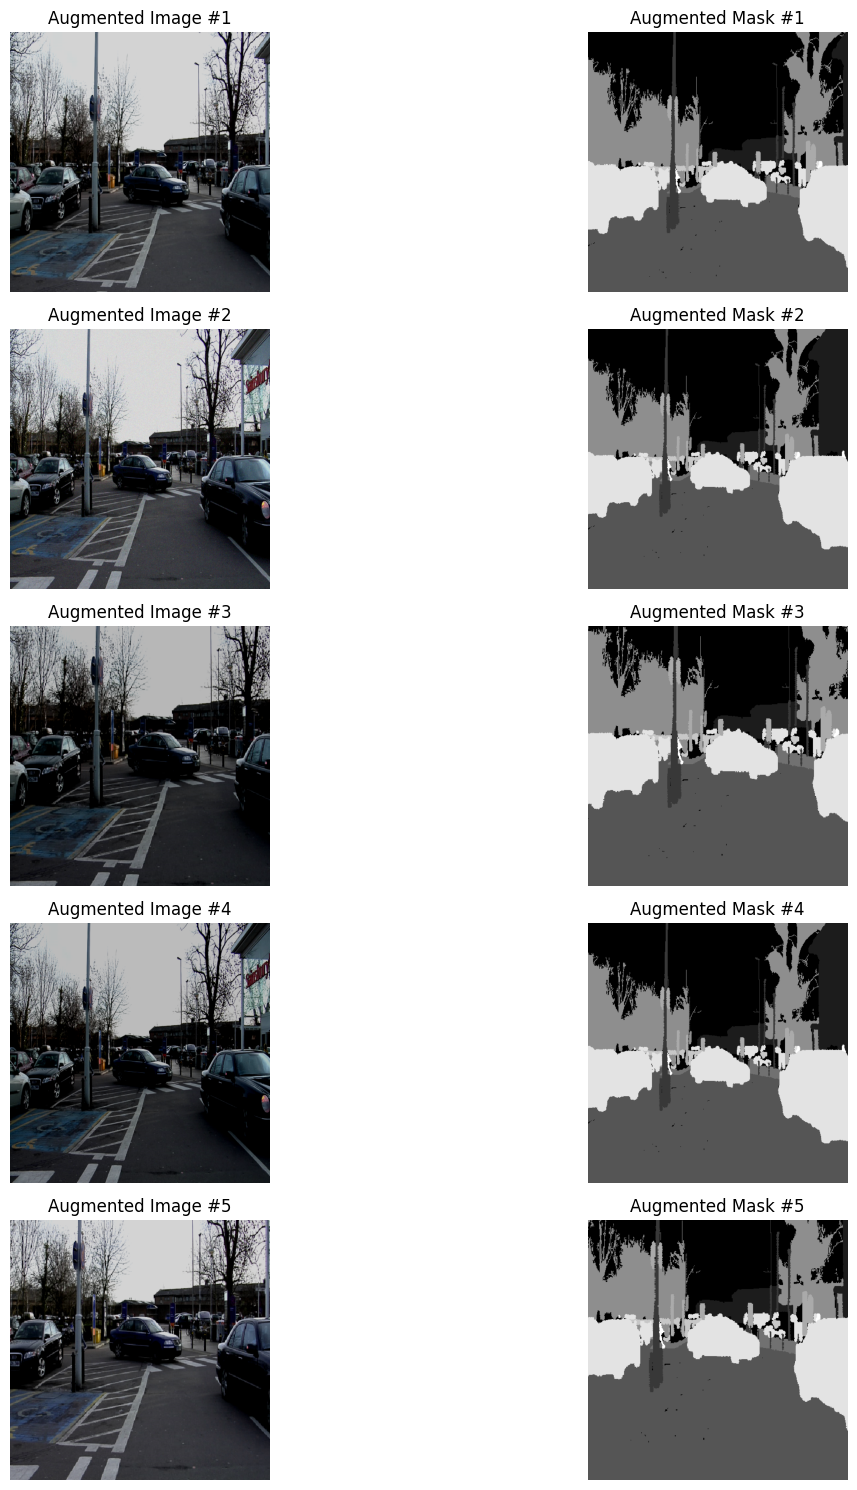

In [23]:
# Augmentation function for image + mask
def augment_image_mask(img, mask):
    # Simulated zoom-in using random crop + resize
    if tf.random.uniform([]) < 0.5:
        crop_scale = tf.random.uniform([], 0.8, 1.0)
        new_h = tf.cast(512 * crop_scale, tf.int32)
        new_w = tf.cast(512 * crop_scale, tf.int32)

        combined = tf.concat([img, tf.cast(mask[..., tf.newaxis], tf.float32)], axis=-1)
        combined = tf.image.random_crop(combined, [new_h, new_w, 4])
        combined = tf.image.resize(combined, [512, 512], method='nearest')

        img = combined[..., :3]
        mask = tf.cast(tf.squeeze(combined[..., 3:]), tf.uint8)

    # Brightness adjustment
    if tf.random.uniform([]) < 0.5:
        img = tf.image.random_brightness(img, max_delta=0.3)

    # Contrast adjustment
    if tf.random.uniform([]) < 0.5:
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)

    # Saturation adjustment
    if tf.random.uniform([]) < 0.5:
        img = tf.image.random_saturation(img, lower=0.7, upper=1.3)

    # Hue adjustment
    if tf.random.uniform([]) < 0.5:
        img = tf.image.random_hue(img, max_delta=0.05)

    # Add Gaussian noise
    if tf.random.uniform([]) < 0.3:
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.02)
        img = tf.clip_by_value(img + noise, 0.0, 1.0)

    return img, mask


# Modify create_dataset to optionally include augmentation
def create_dataset(img_paths, mask_paths, batch_size, shuffle=True, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(img_paths))
    dataset = dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(augment_image_mask, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Example: create datasets with augmentation applied only to training set
batch_size = 8
train_ds = create_dataset(train_img, train_mask, batch_size, shuffle=True, augment=True)
val_ds = create_dataset(val_img, val_mask, batch_size, shuffle=False, augment=False)
test_ds = create_dataset(test_img, test_mask, batch_size, shuffle=False, augment=False)


# Functions to visualize augmentations (optional, useful for inspection)
def get_single_image_mask(dataset):
    for img_batch, mask_batch in dataset.take(1):
        img = img_batch[0]
        mask = mask_batch[0]
        return img, mask

def visualize_multiple_augmentations(img, mask, augment_func, times=5):
    plt.figure(figsize=(15, 3 * times))
    for i in range(times):
        aug_img, aug_mask = augment_func(img, mask)

        plt.subplot(times, 2, i*2+1)
        plt.imshow(aug_img.numpy())
        plt.title(f"Augmented Image #{i+1}")
        plt.axis('off')

        plt.subplot(times, 2, i*2+2)
        plt.imshow(aug_mask.numpy(), cmap='gray')
        plt.title(f"Augmented Mask #{i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example visualization
img, mask = get_single_image_mask(train_ds)
visualize_multiple_augmentations(img, mask, augment_image_mask, times=5)

Image + Mask Augmentation Function (augment_image_mask)

* Simulates zoom-in by randomly cropping both image and mask, then resizing back to 512x512 with nearest neighbor interpolation with 50% probability
* Applies random brightness adjustment with 50% probability
* Applies random contrast adjustment with 50% probability
* Applies random saturation adjustment with 50% probability
* Applies random hue adjustment with 50% probability
* Adds Gaussian noise (mean=0, std=0.02) with 30% probability, clipping pixel values to [0, 1]
* Ensures the mask remains consistent and properly formatted during augmentation

Dataset Creation Function (create_dataset)

* Creates a TensorFlow dataset from image and mask file paths
* Optionally shuffles the dataset (default is True)
* Loads and preprocesses images and masks using load_image_mask
* Applies augmentation if augment=True (typically for training data)
* Batches and prefetches data for optimized training performance

Visualization Utilities

* get_single_image_mask: extracts one image-mask pair from a dataset for visualization
* visualize_multiple_augmentations: applies augmentation multiple times to the same image-mask pair and plots results side-by-side

# 7. Custom metrics definition (IoU)

In [8]:
class ArgmaxMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name='iou', **kwargs):
        super(ArgmaxMeanIoU, self).__init__(num_classes=num_classes, name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predicted probabilities/logits to class labels using argmax
        y_pred = tf.argmax(y_pred, axis=-1)

        return super().update_state(y_true, y_pred, sample_weight)


ArgmaxMeanIoU Metric Class

* Inherits from TensorFlow’s built-in MeanIoU metric
* Overrides the update_state method to convert model predictions (probabilities or logits) into discrete class labels using argmax
* This conversion ensures correct calculation of Mean Intersection over Union (IoU) for multi-class segmentation tasks
* Takes the number of classes as an input parameter during initialization
* Can be used as a metric during model training and evaluation to measure segmentation accuracy


# 8. U-net architecture

In [9]:
def create_model(base_filters=16):
    num_classes = 11
    inputs = keras.Input(shape=(512, 512, 3))

    # Encoder
    c1 = keras.layers.Conv2D(base_filters, 3, activation='relu', padding='same')(inputs)
    c1 = keras.layers.Conv2D(base_filters, 3, activation='relu', padding='same')(c1)
    p1 = keras.layers.MaxPooling2D(2)(c1)

    c2 = keras.layers.Conv2D(base_filters*2, 3, activation='relu', padding='same')(p1)
    c2 = keras.layers.Conv2D(base_filters*2, 3, activation='relu', padding='same')(c2)
    p2 = keras.layers.MaxPooling2D(2)(c2)

    c3 = keras.layers.Conv2D(base_filters*4, 3, activation='relu', padding='same')(p2)
    c3 = keras.layers.Conv2D(base_filters*4, 3, activation='relu', padding='same')(c3)
    p3 = keras.layers.MaxPooling2D(2)(c3)

    c4 = keras.layers.Conv2D(base_filters*8, 3, activation='relu', padding='same')(p3)
    c4 = keras.layers.Conv2D(base_filters*8, 3, activation='relu', padding='same')(c4)
    p4 = keras.layers.MaxPooling2D(2)(c4)

    # Bottleneck
    b = keras.layers.Conv2D(base_filters*16, 3, activation='relu', padding='same')(p4)
    b = keras.layers.Conv2D(base_filters*16, 3, activation='relu', padding='same')(b)

    # Decoder
    u1 = keras.layers.UpSampling2D(2)(b)
    u1 = keras.layers.Concatenate()([u1, c4])
    c5 = keras.layers.Conv2D(base_filters*8, 3, activation='relu', padding='same')(u1)
    c5 = keras.layers.Conv2D(base_filters*8, 3, activation='relu', padding='same')(c5)

    u2 = keras.layers.UpSampling2D(2)(c5)
    u2 = keras.layers.Concatenate()([u2, c3])
    c6 = keras.layers.Conv2D(base_filters*4, 3, activation='relu', padding='same')(u2)
    c6 = keras.layers.Conv2D(base_filters*4, 3, activation='relu', padding='same')(c6)

    u3 = keras.layers.UpSampling2D(2)(c6)
    u3 = keras.layers.Concatenate()([u3, c2])
    c7 = keras.layers.Conv2D(base_filters*2, 3, activation='relu', padding='same')(u3)
    c7 = keras.layers.Conv2D(base_filters*2, 3, activation='relu', padding='same')(c7)

    u4 = keras.layers.UpSampling2D(2)(c7)
    u4 = keras.layers.Concatenate()([u4, c1])
    c8 = keras.layers.Conv2D(base_filters, 3, activation='relu', padding='same')(u4)
    c8 = keras.layers.Conv2D(base_filters, 3, activation='relu', padding='same')(c8)

    # Output layer
    outputs = keras.layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(c8)

    return keras.Model(inputs, outputs)


U-Net Model Architecture (create_model)

* Input shape: (512, 512, 3) for RGB images
* Number of classes: 11 (for multi-class segmentation)

Encoder:
* Four encoding blocks, each consisting of two Conv2D layers (3x3 kernel, ReLU activation, same padding)
* Filters start at `base_filters` (default 16) and double at each downsampling step (16, 32, 64, 128)
* Each block is followed by a MaxPooling2D layer (2x2) to downsample spatial dimensions by 2

Bottleneck:
* Two Conv2D layers with 256 filters (base_filters * 16)
* Acts as the deepest feature extractor before upsampling

Decoder:
* Four decoding blocks, each starting with UpSampling2D (2x2) to double spatial dimensions
* Skip connections concatenate corresponding encoder outputs to preserve spatial information
* Two Conv2D layers per block, filters decrease by half each step (128, 64, 32, 16)

Output:
* Final Conv2D layer with `num_classes` filters and softmax activation to produce per-pixel class probabilities

Returns:
* A compiled Keras Model ready for training on segmentation tasks


# 9. Selection best loss & optimizer



Starting combination testing...


Optimizer/loss combinations:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/30


I0000 00:00:1752577005.263321     102 service.cc:148] XLA service 0x7ade14002b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752577005.264479     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752577005.264518     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1752577005.905530     102 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1752577006.326913     102 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752577030.250840     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.2202 - iou: 0.0367 - loss: 2.1816

W0000 00:00:1752577041.721269     100 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
E0000 00:00:1752577051.533704     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752577051.787784     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.2215 - iou: 0.0370 - loss: 2.1781

W0000 00:00:1752577066.320145     102 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1752577074.721012     101 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


46/46 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.2227 - iou: 0.0373 - loss: 2.1748 - val_accuracy: 0.3963 - val_iou: 0.0891 - val_loss: 1.7654
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 286ms/step - accuracy: 0.4111 - iou: 0.0775 - loss: 1.6887 - val_accuracy: 0.3866 - val_iou: 0.0805 - val_loss: 1.6208
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 290ms/step - accuracy: 0.4303 - iou: 0.0825 - loss: 1.5185 - val_accuracy: 0.4340 - val_iou: 0.1035 - val_loss: 1.4519
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 292ms/step - accuracy: 0.4795 - iou: 0.1127 - loss: 1.4015 - val_accuracy: 0.5907 - val_iou: 0.1552 - val_loss: 1.4223
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 297ms/step - accuracy: 0.5417 - iou: 0.1387 - loss: 1.3230 - val_accuracy: 0.5414 - val_iou: 0.1551 - val_loss: 1.4056
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 299ms/step - accuracy: 0.5822 - iou: 0.1575 - loss: 1.2155 - val_accuracy: 0.5923 - val_iou: 0.1680 - val_loss: 1.2632
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 299ms/

W0000 00:00:1752577926.392410     101 assert_op.cc:38] Ignoring Assert operator compile_loss/dice_ce_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.1951 - iou: 0.0360 - loss: 1.6400

W0000 00:00:1752577942.838715     100 assert_op.cc:38] Ignoring Assert operator compile_loss/dice_ce_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.1962 - iou: 0.0363 - loss: 1.6375

W0000 00:00:1752577948.250403     100 assert_op.cc:38] Ignoring Assert operator compile_loss/dice_ce_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1752577950.194106     103 assert_op.cc:38] Ignoring Assert operator compile_loss/dice_ce_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 452ms/step - accuracy: 0.1973 - iou: 0.0366 - loss: 1.6351 - val_accuracy: 0.3876 - val_iou: 0.0786 - val_loss: 1.3443
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 310ms/step - accuracy: 0.3918 - iou: 0.0700 - loss: 1.2755 - val_accuracy: 0.4246 - val_iou: 0.0818 - val_loss: 1.2095
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 307ms/step - accuracy: 0.4596 - iou: 0.0930 - loss: 1.1685 - val_accuracy: 0.5013 - val_iou: 0.1131 - val_loss: 1.1722
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 301ms/step - accuracy: 0.5382 - iou: 0.1269 - loss: 1.1058 - val_accuracy: 0.6246 - val_iou: 0.1706 - val_loss: 1.0443
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 296ms/step - accuracy: 0.6155 - iou: 0.1650 - loss: 0.9907 - val_accuracy: 0.5989 - val_iou: 0.1828 - val_loss: 1.0504
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 297ms/step - accuracy: 0.6404 - iou: 0.1892 - loss: 0.9189 - val_accuracy: 0.6364 - val_iou: 0.1960 - val_loss: 0.9291
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 301

W0000 00:00:1752578365.359632     102 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.1856 - iou: 0.0301 - loss: 2.2843

W0000 00:00:1752578380.832424     100 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.1866 - iou: 0.0303 - loss: 2.2815

W0000 00:00:1752578385.351819     101 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1752578387.033077     100 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


46/46 ━━━━━━━━━━━━━━━━━━━━ 28s 415ms/step - accuracy: 0.1876 - iou: 0.0306 - loss: 2.2788 - val_accuracy: 0.4666 - val_iou: 0.1091 - val_loss: 1.8973
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 301ms/step - accuracy: 0.3385 - iou: 0.0690 - loss: 1.8883 - val_accuracy: 0.3659 - val_iou: 0.0760 - val_loss: 1.8526
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 304ms/step - accuracy: 0.3904 - iou: 0.0809 - loss: 1.7065 - val_accuracy: 0.5103 - val_iou: 0.1172 - val_loss: 1.6119
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 297ms/step - accuracy: 0.4403 - iou: 0.0964 - loss: 1.6301 - val_accuracy: 0.5283 - val_iou: 0.1252 - val_loss: 1.5371
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 301ms/step - accuracy: 0.4947 - iou: 0.1189 - loss: 1.5363 - val_accuracy: 0.6000 - val_iou: 0.1471 - val_loss: 1.4188
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 293ms/step - accuracy: 0.5344 - iou: 0.1329 - loss: 1.4457 - val_accuracy: 0.6211 - val_iou: 0.1540 - val_loss: 1.3234
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 295

W0000 00:00:1752579254.578830     103 assert_op.cc:38] Ignoring Assert operator compile_loss/dice_ce_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.2446 - iou: 0.0294 - loss: 1.4681

W0000 00:00:1752579270.379855     101 assert_op.cc:38] Ignoring Assert operator compile_loss/dice_ce_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.2452 - iou: 0.0296 - loss: 1.4666

W0000 00:00:1752579275.318551     100 assert_op.cc:38] Ignoring Assert operator compile_loss/dice_ce_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1752579277.099710     102 assert_op.cc:38] Ignoring Assert operator compile_loss/dice_ce_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


46/46 ━━━━━━━━━━━━━━━━━━━━ 30s 434ms/step - accuracy: 0.2457 - iou: 0.0298 - loss: 1.4651 - val_accuracy: 0.3896 - val_iou: 0.0751 - val_loss: 1.3764
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 306ms/step - accuracy: 0.3563 - iou: 0.0597 - loss: 1.3186 - val_accuracy: 0.3939 - val_iou: 0.0760 - val_loss: 1.3050
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 309ms/step - accuracy: 0.4008 - iou: 0.0723 - loss: 1.2657 - val_accuracy: 0.3899 - val_iou: 0.0724 - val_loss: 1.2723
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 301ms/step - accuracy: 0.4323 - iou: 0.0929 - loss: 1.2282 - val_accuracy: 0.5645 - val_iou: 0.1382 - val_loss: 1.1822
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 303ms/step - accuracy: 0.4720 - iou: 0.1104 - loss: 1.2045 - val_accuracy: 0.5993 - val_iou: 0.1814 - val_loss: 1.1440
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 300ms/step - accuracy: 0.4744 - iou: 0.1180 - loss: 1.1820 - val_accuracy: 0.6171 - val_iou: 0.1630 - val_loss: 1.0903
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 300

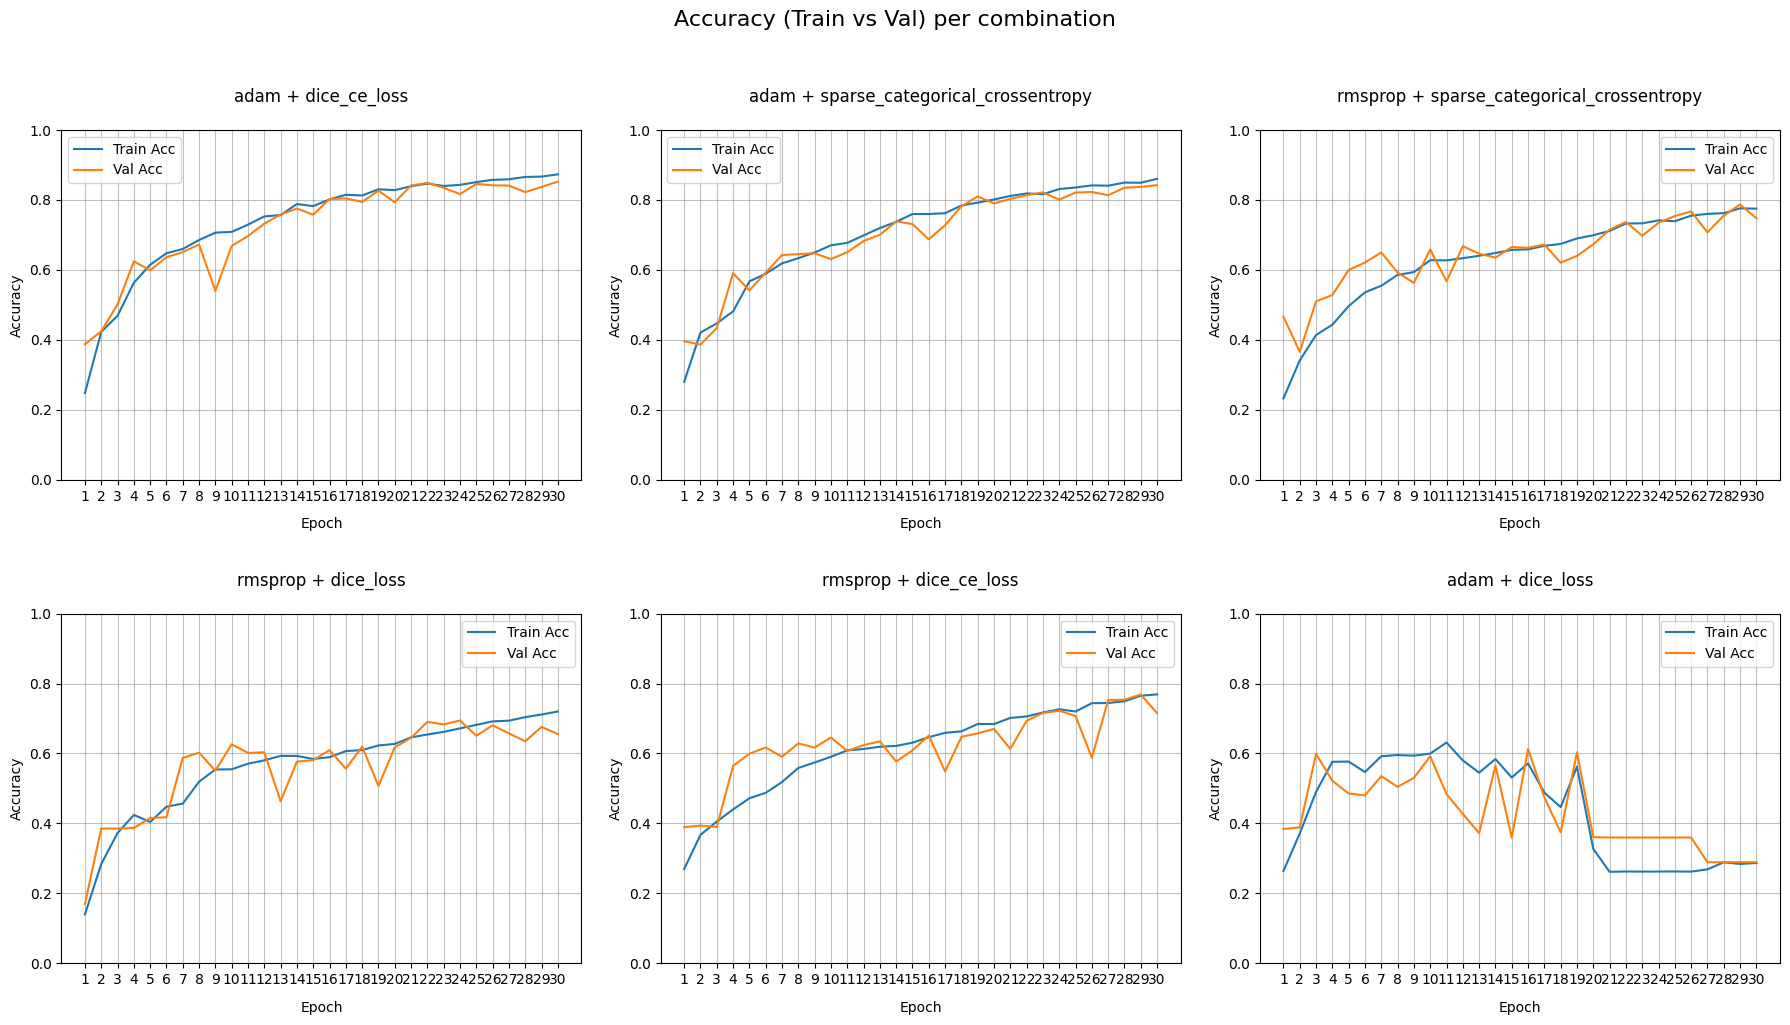

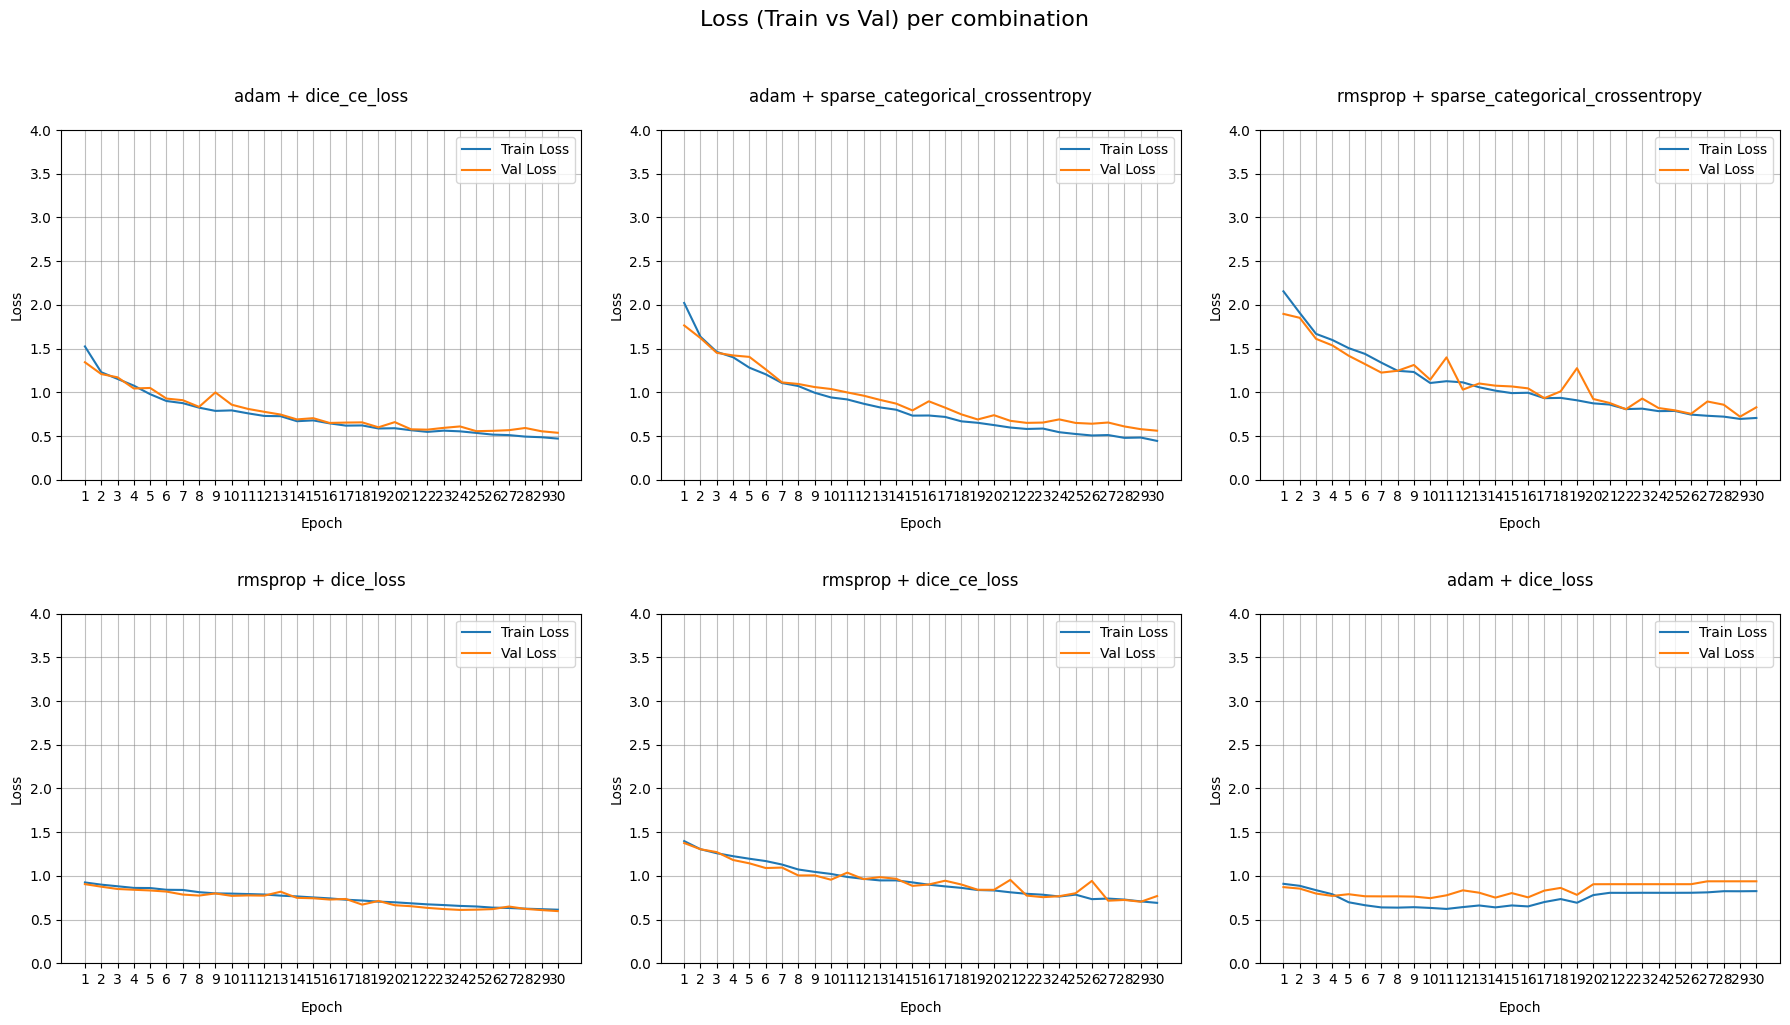

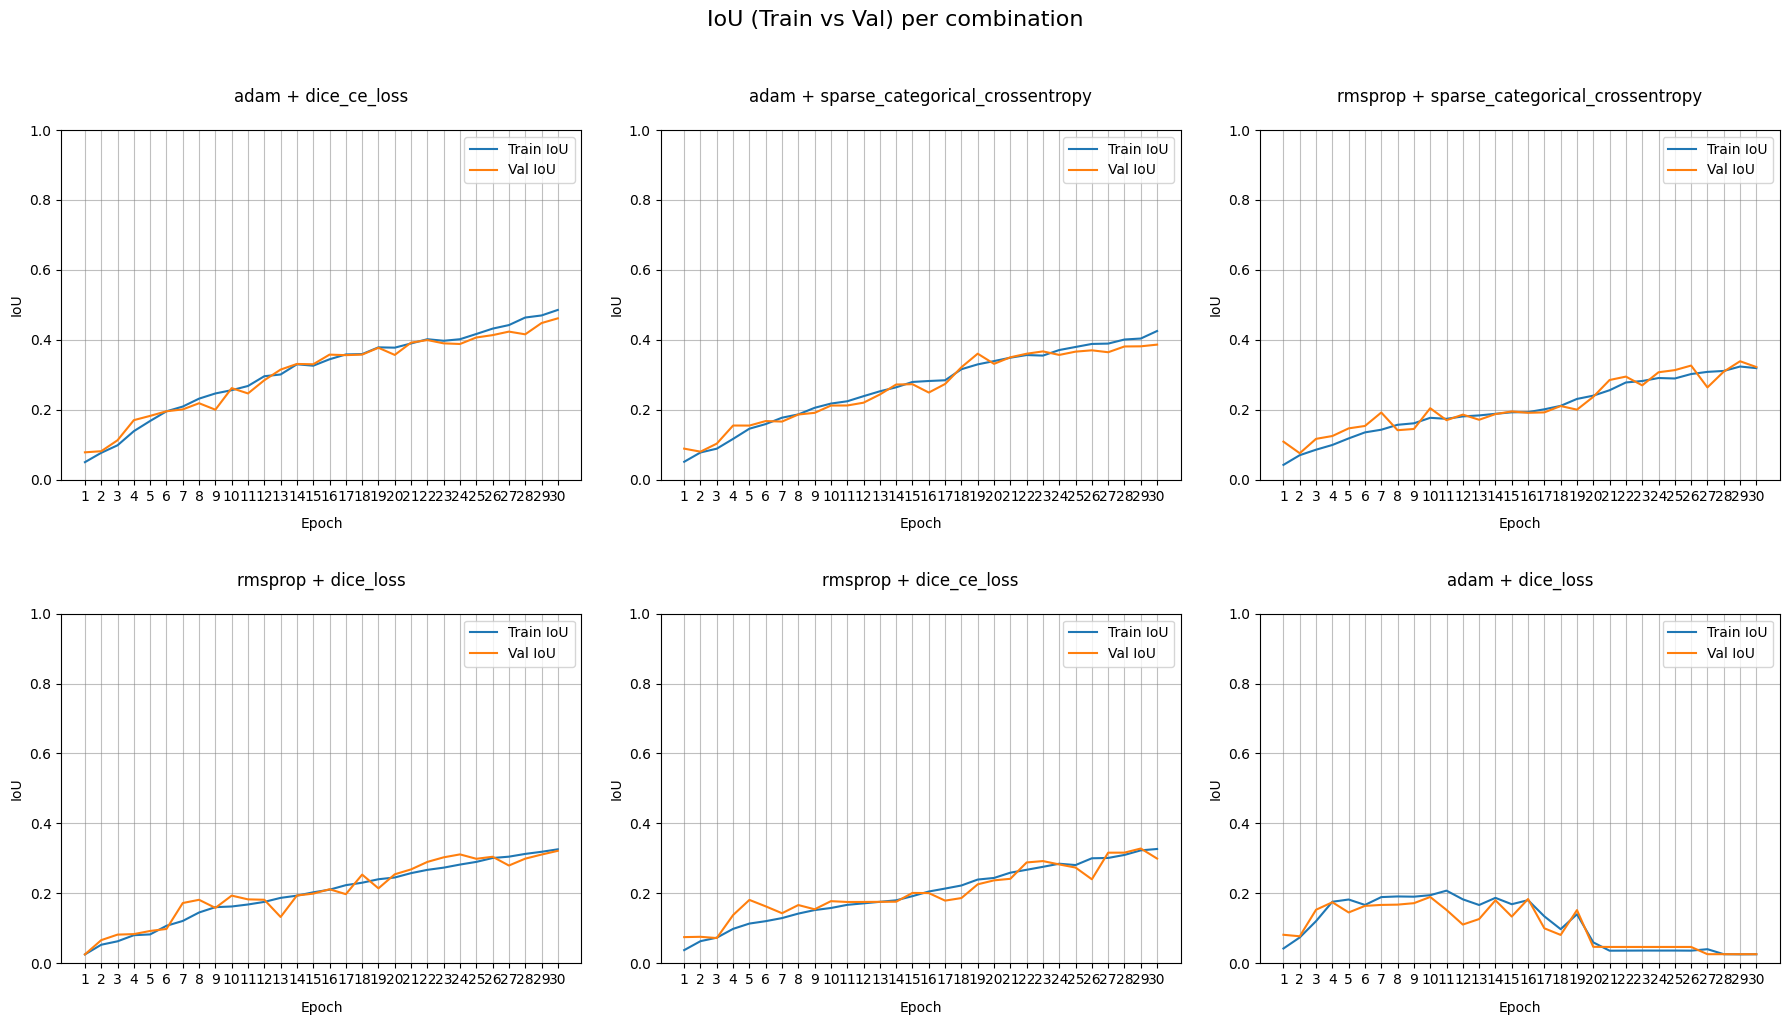

In [10]:
# Parameters
batch_size = 8
num_classes = 11

# Configurations to test
optimizers = ['adam', 'rmsprop']
loss_functions = {
    'sparse_categorical_crossentropy': None,
    'dice_loss': dice_loss,
    'dice_ce_loss': dice_ce_loss
}

# Results
results = []

print("\nStarting combination testing...")
total_combinations = len(optimizers) * len(loss_functions)
combination_pbar = tqdm(total=total_combinations, desc="Optimizer/loss combinations")

# Combination loop
for opt_name in optimizers:
    for loss_name, loss_fn in loss_functions.items():
        model = create_model(base_filters=16)

        model.compile(
            optimizer=opt_name,
            loss=loss_fn if loss_fn else loss_name,
            metrics=['accuracy', ArgmaxMeanIoU(num_classes=num_classes)]
        )

        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=30,
            verbose=1
        )

        # Extract IoU values from history (last epoch)
        val_iou = history.history['val_iou'][-1]
        train_iou = history.history['iou'][-1]

        results.append({
            'optimizer': opt_name,
            'loss': loss_name,
            'val_iou': val_iou,
            'train_iou': train_iou,
            'model': model,
            'history': history.history
        })

        combination_pbar.update(1)

combination_pbar.close()
print_time_elapsed(start_time, "Combination testing completed")

# Find best model (based on val IoU)
best_result = max(results, key=lambda x: x['val_iou'])
best_model = best_result['model']

best_loss_name = best_result['loss']
best_optimizer_name = best_result['optimizer']

print("Best combination:")
print(f"Optimizer: {best_result['optimizer']}")
print(f"Loss: {best_result['loss']}")
print(f"Validation IoU: {best_result['val_iou']:.4f}")

# Sort results by val_iou descending
sorted_results = sorted(results, key=lambda x: x["val_iou"], reverse=True)

# Print results
print("\nGRID SEARCH RESULTS (sorted by val_iou):\n")
for idx, res in enumerate(sorted_results):
    print(f"#{idx + 1}")
    print(f"  Optimizer: {res['optimizer']}")
    print(f"  Loss Function: {res['loss']}")
    print(f"  Validation IoU: {res['val_iou']:.4f}")
    print(f"  Final Val Accuracy: {res['history']['val_accuracy'][-1]:.4f}")
    print(f"  Final Val Loss: {res['history']['val_loss'][-1]:.4f}")
    print(f"  Final Train IoU: {res['train_iou']:.4f}")
    print("-" * 50)

# Create figures and axes
fig_acc, axes_acc = plt.subplots(2, 3, figsize=(18, 10))
fig_acc.suptitle("Accuracy (Train vs Val) per combination", fontsize=16, y=1.02)

fig_loss, axes_loss = plt.subplots(2, 3, figsize=(18, 10))
fig_loss.suptitle("Loss (Train vs Val) per combination", fontsize=16, y=1.02)

fig_iou, axes_iou = plt.subplots(2, 3, figsize=(18, 10))
fig_iou.suptitle("IoU (Train vs Val) per combination", fontsize=16, y=1.02)

for i, result in enumerate(sorted_results):
    row = i // 3
    col = i % 3
    history = result["history"]
    epochs = list(range(1, len(history["accuracy"]) + 1))
    title = f"{result['optimizer']} + {result['loss']}"

    # Plot Accuracy
    ax_acc = axes_acc[row][col]
    ax_acc.plot(epochs, history["accuracy"], label="Train Acc")
    ax_acc.plot(epochs, history["val_accuracy"], label="Val Acc")
    ax_acc.set_title(title, pad=20)
    ax_acc.set_xlabel("Epoch", labelpad=10)
    ax_acc.set_ylabel("Accuracy")
    ax_acc.set_ylim(0, 1)
    ax_acc.set_xticks(epochs)  # Show all integer values
    ax_acc.grid(True, linestyle='-', which='both', color='gray', alpha=0.5)  # Grid lines
    ax_acc.legend()

    # Plot Loss
    ax_loss = axes_loss[row][col]
    ax_loss.plot(epochs, history["loss"], label="Train Loss")
    ax_loss.plot(epochs, history["val_loss"], label="Val Loss")
    ax_loss.set_title(title, pad=20)
    ax_loss.set_xlabel("Epoch", labelpad=10)
    ax_loss.set_ylabel("Loss")
    ax_loss.set_ylim(0, 4)
    ax_loss.set_xticks(epochs)
    ax_loss.grid(True, linestyle='-', which='both', color='gray', alpha=0.5)
    ax_loss.legend()

    # Plot IoU
    ax_iou = axes_iou[row][col]
    ax_iou.plot(epochs, history["iou"], label="Train IoU")
    ax_iou.plot(epochs, history["val_iou"], label="Val IoU")
    ax_iou.set_title(title, pad=20)
    ax_iou.set_xlabel("Epoch", labelpad=10)
    ax_iou.set_ylabel("IoU")
    ax_iou.set_ylim(0, 1)
    ax_iou.set_xticks(epochs)
    ax_iou.grid(True, linestyle='-', which='both', color='gray', alpha=0.5)
    ax_iou.legend()

# Final spacing adjustment
for fig in [fig_acc, fig_loss, fig_iou]:
    fig.tight_layout(h_pad=3.0, w_pad=2.0)
    fig.subplots_adjust(top=0.9)

plt.show()

Hyperparameter Grid Search for Optimizer and Loss Function

* Defines batch size and number of segmentation classes
* Specifies two optimizers to test: 'adam' and 'rmsprop'
* Defines three loss functions: sparse categorical crossentropy, dice loss, and combined dice + crossentropy loss
* Initializes an empty list to store results for each combination

Combination Loop:
* For each optimizer and each loss function:
  - Creates a new model instance with default filters
  - Compiles the model with the current optimizer, loss, and metrics (accuracy and custom IoU metric)
  - Trains the model on training dataset and validates on validation dataset for 30 epochs
  - Extracts final train and validation IoU scores
  - Stores results including optimizer, loss, IoU scores, trained model, and training history

Post-Training:
* Identifies the best model based on highest validation IoU
* Prints the best optimizer, loss function, and validation IoU
* Sorts all results by validation IoU in descending order
* Prints a summary of all tested combinations with optimizer, loss, validation IoU, final validation accuracy, validation loss, and training IoU

Visualization:
* Creates three figures with subplots to visualize metrics per combination:
  - Accuracy (train vs val)
  - Loss (train vs val)
  - IoU (train vs val)
* Plots per-epoch training and validation metrics for each combination
* Adds grid lines, legends, titles, and axis labels for clarity
* Adjusts layout spacing and displays the plots


In [ ]:
# Conversion helper
def convert_history(history):
    return {
        metric: [float(v) for v in values]
        for metric, values in history.items()
    }

# Extract and convert historical data
full_history_data = []

for res in results:
    record = {
        'optimizer': res['optimizer'],
        'loss': res['loss'],
        'val_iou': float(res['val_iou']),
        'history': convert_history(res['history'])
    }
    full_history_data.append(record)

# Save to JSON
with open('full_training_histories.json', 'w') as f:
    json.dump(full_history_data, f, indent=2)

print("\n Saved all training histories in 'full_training_histories.json'")


💾 Saved all training histories in 'full_training_histories.json'


# 10. Model building function with hyperparameters (for tuning)

In [26]:
def build_model_wrapper(best_loss_name, best_optimizer_name):
    def build_model(hp):
        base_filters = hp.Choice('base_filters', values=[8, 16, 32])
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        # Only include parameters relevant to the selected loss function
        if best_loss_name == 'dice_ce_loss':
            alpha = hp.Float('alpha', min_value=0.2, max_value=0.8, step=0.1)
        elif best_loss_name == 'dice_loss':
            smooth = hp.Float('smooth', min_value=0.2, max_value=0.8, step=0.1)
        elif best_loss_name == 'sparse_categorical_crossentropy':
            pass  # No additional hyperparameters required

        # Model construction
        model = create_model(base_filters=base_filters)

        # Select optimizer
        optimizer_map = {
            'adam': keras.optimizers.Adam(learning_rate=learning_rate),
            'rmsprop': keras.optimizers.RMSprop(learning_rate=learning_rate),
        }
        optimizer = optimizer_map.get(best_optimizer_name)

        # Select loss function
        if best_loss_name == 'dice_ce_loss':
            loss_fn = dice_ce_loss_wrapper(alpha)
        elif best_loss_name == 'dice_loss':
            loss_fn = dice_loss_wrapper(smooth)
        elif best_loss_name == 'sparse_categorical_crossentropy':
            loss_fn = crossentropy_loss_wrapper()

        # Compile the model with the selected configuration
        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=[ArgmaxMeanIoU(num_classes=11, name='iou'), 'accuracy']
        )

        return model

    return build_model


Hypermodel Builder Wrapper for Keras Tuner

* Defines 'build_model_wrapper' which takes the best loss and optimizer names as input
* Returns a 'build_model' function suitable for use in hyperparameter tuning
* 'build_model' defines hyperparameters to tune:
  * 'base_filters': choice among [8, 16, 32]
  * 'learning_rate': choice among [1e-2, 1e-3, 1e-4]
  * Conditional hyperparameters depending on the loss function:
    * For 'dice_ce_loss': tunes 'alpha' (float between 0.2 and 0.8)
    * For 'dice_loss': tunes 'smooth' (float between 0.2 and 0.8)
    * For 'sparse_categorical_crossentropy': no extra hyperparameters
* Constructs the model using the 'create_model' function with selected base filters
* Maps optimizer names to their respective Keras optimizer instances with chosen learning rate
* Wraps the loss functions appropriately with their hyperparameters if needed
* Compiles the model with the chosen optimizer, loss function, and metrics (IoU and accuracy)
* Returns the compiled model ready for hyperparameter tuning


# 11. Hyperparameter tuning setup and launch

In [27]:
# Initialize the Keras Tuner with Hyperband strategy
tuner = kt.Hyperband(
    build_model_wrapper(best_loss_name, best_optimizer_name),
    objective=kt.Objective("val_iou", direction="max"),  # Maximize validation IoU
    max_epochs=20,
    factor=3,
    hyperband_iterations=1,
    directory='hyperparam_tuning',
    project_name='camvid_optim'
)

# Early stopping callback to halt training when validation IoU stops improving
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_iou',
    patience=5,
    mode='max',
    restore_best_weights=True
)

start_time = time.time()
print("Starting hyperparameter search...")

# Launch the hyperparameter search
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[stop_early]
)

# Retrieve the best hyperparameter set found during search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"\n Best hyperparameters found:")
print(f"- Base filters: {best_hps.get('base_filters')}")
print(f"- Learning rate: {best_hps.get('learning_rate')}")
print(f"- Best loss: {best_loss_name}")
print(f"- Best optimizer: {best_optimizer_name}")

# Print additional loss-specific hyperparameters, if applicable
if best_loss_name == 'dice_ce_loss':
    print(f"- Alpha (CE weight): {best_hps.get('alpha')}")
elif best_loss_name == 'dice_loss':
    print(f"- Smooth: {best_hps.get('smooth')}")
elif best_loss_name == 'sparse_categorical_crossentropy':
    pass

print_time_elapsed(start_time, "Hyperparameter search completed")

# Save the best hyperparameters to a text file
with open('best_hyperparameters.txt', 'w') as f:
    f.write(f"base_filters: {best_hps.get('base_filters')}\n")
    f.write(f"learning_rate: {best_hps.get('learning_rate')}\n")
    f.write(f"loss: {best_loss_name}\n")
    f.write(f"optimizer: {best_optimizer_name}\n")
    if best_loss_name == 'dice_ce_loss':
        f.write(f"alpha: {best_hps.get('alpha')}\n")
    elif best_loss_name == 'dice_loss':
        f.write(f"smooth: {best_hps.get('smooth')}\n")
    elif best_loss_name == 'sparse_categorical_crossentropy':
        pass

# Extract valid trials (only those with a valid score)
trials = [t for t in tuner.oracle.get_best_trials(num_trials=100) if t.score is not None]

results = []
for trial in trials:
    hp = trial.hyperparameters
    trial_data = {
        'trial_id': trial.trial_id,
        'val_iou': trial.score,
        'epochs': trial.best_step,
        'base_filters': hp.get('base_filters'),
        'learning_rate': hp.get('learning_rate'),
    }

    # Add loss-specific parameter if available
    if best_loss_name == 'dice_ce_loss':
        trial_data['alpha'] = hp.get('alpha')
    elif best_loss_name == 'dice_loss':
        trial_data['smooth'] = hp.get('smooth')
    elif best_loss_name == 'sparse_categorical_crossentropy':
        pass

    results.append(trial_data)

# Create a DataFrame from all trial results
df_results = pd.DataFrame(results)

# Sort by descending validation IoU
df_results = df_results.sort_values('val_iou', ascending=False)

# Display the top 10 trials
print("\n Top 10 trials sorted by val_iou:")
print(df_results.head(10).to_string(index=False))

# Save all trial results to a CSV file
df_results.to_csv('tuning_trials_summary.csv', index=False)
print("\n Results saved to 'tuning_trials_summary.csv'")


Trial 30 Complete [00h 03m 18s]
val_iou: 0.09302682429552078

Best val_iou So Far: 0.452633261680603
Total elapsed time: 01h 20m 50s

 Best hyperparameters found:
- Base filters: 32
- Learning rate: 0.001
- Best loss: dice_ce_loss
- Best optimizer: adam
- Alpha (CE weight): 0.2
Hyperparameter search completed - elapsed time: 4849.62 sec

 Top 10 trials sorted by val_iou:
trial_id  val_iou  epochs  base_filters  learning_rate  alpha
    0027 0.452633      19            32         0.0010    0.2
    0016 0.411557      12            32         0.0010    0.5
    0017 0.373245      12            16         0.0010    0.4
    0024 0.279482      10            32         0.0001    0.4
    0012 0.212187       3            32         0.0010    0.5
    0015 0.199815       3            16         0.0010    0.4
    0013 0.189288       0            16         0.0010    0.6
    0014 0.172759       2            16         0.0001    0.6
    0026 0.171729      18             8         0.0001    0.5
    00

* Initializes Keras Tuner with Hyperband strategy to optimize model hyperparameters  
* Uses build_model_wrapper with best loss and optimizer names to create a tunable model builder  
* Hyperband tuner objective: maximize validation IoU (val_iou)  
* Configured for max 30 epochs per trial, with early stopping after 5 epochs of no improvement  
* Runs search on training and validation datasets (train_ds, val_ds)  
* After tuning, retrieves and prints best hyperparameters: base_filters (8,16,32), learning_rate (1e-2, 1e-3, 1e-4), plus loss-specific params alpha or smooth if applicable  
* Saves best hyperparameters to a text file for reproducibility  
* Collects all valid trials into a DataFrame sorted by val_iou, prints top 10 trials, and saves full results to CSV  
* Automates hyperparameter tuning to efficiently improve segmentation model performance without manual guesswork  


# 12. Final model training with best hyperparameters

In [28]:
# Start final training using the best hyperparameters found by the tuner
print("\nTraining final model with best hyperparameters...")
model = tuner.hypermodel.build(best_hps)

# Callback to log training metrics to a CSV file
csv_logger = keras.callbacks.CSVLogger('training_metrics.csv')

# Train the model with early stopping, live progress, and checkpointing
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[
        stop_early,  # Stop training early if validation IoU doesn't improve
        TqdmCallback(verbose=1),  # Show progress bar with live metrics
        keras.callbacks.ModelCheckpoint(
            'best_model.h5',        # Save the best model based on val_iou
            save_best_only=True,
            monitor='val_iou',
            mode='max'
        ),
        csv_logger  # Save training and validation metrics to CSV
    ]
)



Training final model with best hyperparameters...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 49s 811ms/step - accuracy: 0.2389 - iou: 0.0382 - loss: 1.2430 - val_accuracy: 0.3864 - val_iou: 0.0892 - val_loss: 1.0522
Epoch 2/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 31s 669ms/step - accuracy: 0.4374 - iou: 0.0912 - loss: 1.0161 - val_accuracy: 0.5829 - val_iou: 0.1391 - val_loss: 0.9557
Epoch 3/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 31s 667ms/step - accuracy: 0.5061 - iou: 0.1252 - loss: 0.9658 - val_accuracy: 0.6216 - val_iou: 0.1852 - val_loss: 0.8859
Epoch 4/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 31s 661ms/step - accuracy: 0.5746 - iou: 0.1564 - loss: 0.9076 - val_accuracy: 0.5266 - val_iou: 0.1568 - val_loss: 0.8546
Epoch 5/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 31s 670ms/step - accuracy: 0.6073 - iou: 0.1751 - loss: 0.8582 - val_accuracy: 0.6170 - val_iou: 0.2013 - val_loss: 0.8181
Epoch 6/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 31s 670ms/step - accuracy: 0.6333 - iou: 0.2017 - loss: 0.8199 - val_accuracy: 0.6182 - val_iou: 0.2110 - val_loss: 0.8151
Epoch 7/40
46/46 ━━━━━━━━━━━━━━━━━

* Starts final training of the model using the best hyperparameters found by the tuner  
* Builds the model with tuner.hypermodel.build(best_hps)  
* Sets up CSVLogger callback to record training metrics to 'training_metrics.csv'  
* Trains the model on train_ds with validation on val_ds for up to 40 epochs  
* Uses EarlyStopping callback (stop_early) to halt training if validation IoU stops improving  
* Uses TqdmCallback for live progress bar and metric display during training  
* Uses ModelCheckpoint callback to save the best model (best_model.h5) based on highest val_iou  
* Saves all training and validation metrics during training to CSV for later analysis  


# 13. Final evaluation on test set


In [29]:
print("\nEvaluating on test set...")
test_loss, test_iou, test_acc = model.evaluate(test_ds)
print(f"Test IoU: {test_iou:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Save test results to file
with open('final_results.txt', 'w') as f:
    f.write(f"Test IoU: {test_iou}\n")
    f.write(f"Test Accuracy: {test_acc}\n")
    f.write(f"Test Loss: {test_loss}\n")


Evaluating on test set...
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 304ms/step - accuracy: 0.8114 - iou: 0.4568 - loss: 0.5530
Test IoU: 0.4447
Test Accuracy: 0.8062
Test Loss: 0.5849


# 14. Classes valuation

In [ ]:
import tensorflow as tf

num_classes = 11
class_names = [
    "Sky",
    "Building",
    "Pole",
    "Road",
    "Pavement",
    "Tree",
    "Sign/Symbol",
    "Fence",
    "Car",
    "Pedestrian",
    "Bicyclist"
]

iou_results = []

for cls in range(num_classes):
    metric = tf.keras.metrics.MeanIoU(num_classes=2)
    for x_batch, y_batch in test_ds:
        y_pred = model.predict(x_batch, verbose=0)
        y_pred_labels = tf.argmax(y_pred, axis=-1)

        y_true_cls = tf.cast(tf.equal(y_batch, cls), tf.int32)
        y_pred_cls = tf.cast(tf.equal(y_pred_labels, cls), tf.int32)

        metric.update_state(y_true_cls, y_pred_cls)

    iou_value = metric.result().numpy()
    iou_results.append((cls, iou_value))

iou_results.sort(key=lambda x: x[1], reverse=True)

print("\nIoU per class (sorted):")
for cls_index, iou in iou_results:
    print(f"Class {cls_index:2d} ({class_names[cls_index]:<10}): IoU = {iou:.4f}")



IoU per class (sorted):
Class  3 (Road      ): IoU = 0.9163
Class  0 (Sky       ): IoU = 0.8722
Class  4 (Pavement  ): IoU = 0.7824
Class  5 (Tree      ): IoU = 0.7789
Class  1 (Building  ): IoU = 0.7551
Class  8 (Car       ): IoU = 0.7056
Class 10 (Bicyclist ): IoU = 0.6649
Class  9 (Pedestrian): IoU = 0.5794
Class  7 (Fence     ): IoU = 0.5706
Class  2 (Pole      ): IoU = 0.5594
Class  6 (Sign/Symbol): IoU = 0.5392


# 15. Plot training metrics


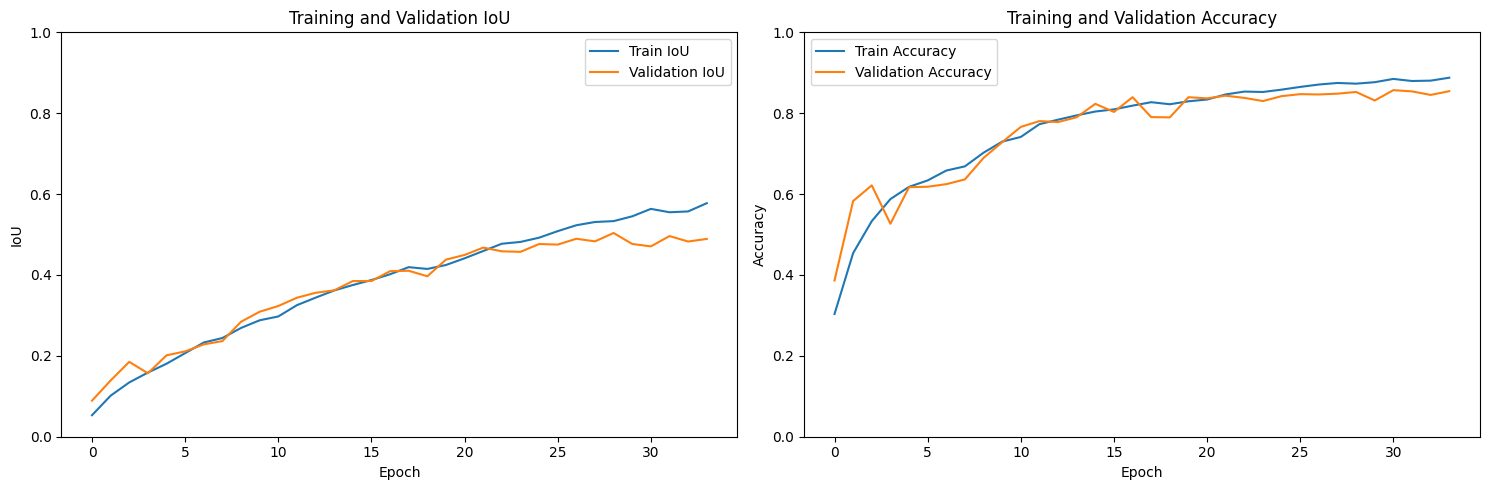

In [33]:
# Create a figure to plot training metrics side by side
plt.figure(figsize=(15, 5))

# Plot IoU for both training and validation sets
plt.subplot(1, 2, 1)
plt.plot(history.history['iou'], label='Train IoU')
plt.plot(history.history['val_iou'], label='Validation IoU')
plt.title('Training and Validation IoU')
plt.ylim(0, 1)
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend()

# Plot accuracy for both training and validation sets
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Adjust layout to prevent overlap and save the plot as an image file
plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()


# 16. Visualize sample predictions

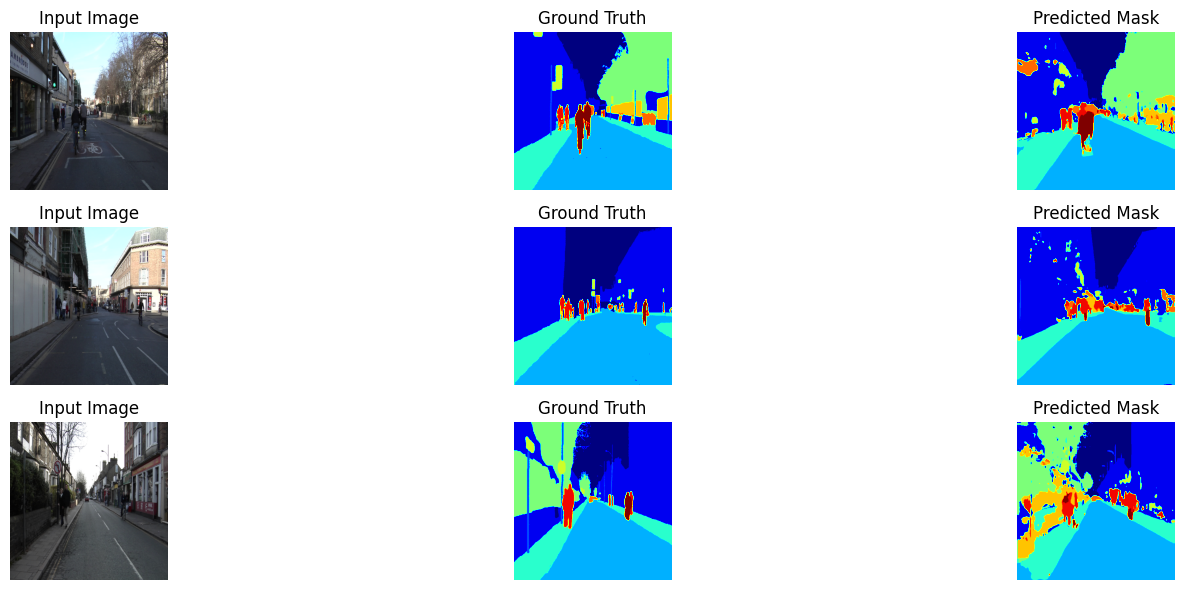

In [50]:
import matplotlib.pyplot as plt
import tensorflow as tf

def extract_images_by_index(dataset, indices):
    images = []
    masks = []

    flat_dataset = dataset.unbatch()
    for i, (img, mask) in enumerate(flat_dataset):
        if i in indices:
            images.append(img)
            masks.append(mask)
        if len(images) == len(indices):
            break
    return images, masks

def plot_selected_predictions(model, test_ds, num_classes, indices=[0, 50, 100]):
    images, masks = extract_images_by_index(test_ds, indices)

    plt.figure(figsize=(18, 6))

    for i in range(3):
        image = images[i]
        true_mask = masks[i]

        # Predizione
        pred = model.predict(tf.expand_dims(image, axis=0), verbose=0)
        pred_mask = tf.argmax(pred[0], axis=-1)

        # Immagine originale
        plt.subplot(3, 3, i * 3 + 1)
        plt.imshow(image)
        plt.title(f"Input Image")
        plt.axis("off")

        # Maschera ground truth
        plt.subplot(3, 3, i * 3 + 2)
        plt.imshow(true_mask, cmap="jet", vmin=0, vmax=num_classes - 1)
        plt.title("Ground Truth")
        plt.axis("off")

        # Maschera predetta
        plt.subplot(3, 3, i * 3 + 3)
        plt.imshow(pred_mask, cmap="jet", vmin=0, vmax=num_classes - 1)
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.savefig("selected_predictions.png", dpi=300)
    plt.show()
plot_selected_predictions(model, test_ds, num_classes, indices=[0, 50, 100])


# 17. Visualize best model


In [53]:
import h5py

def print_h5_structure(name, obj):
    print(name)
    if isinstance(obj, h5py.Dataset):
        print(f"  Dataset shape: {obj.shape}, dtype: {obj.dtype}")

# Apri il file h5 in lettura
with h5py.File('best_model.h5', 'r') as f:
    f.visititems(print_h5_structure)


model_weights
model_weights/concatenate_4
model_weights/concatenate_5
model_weights/concatenate_6
model_weights/concatenate_7
model_weights/conv2d_19
model_weights/conv2d_19/conv2d_19
model_weights/conv2d_19/conv2d_19/bias
  Dataset shape: (32,), dtype: float32
model_weights/conv2d_19/conv2d_19/kernel
  Dataset shape: (3, 3, 3, 32), dtype: float32
model_weights/conv2d_20
model_weights/conv2d_20/conv2d_20
model_weights/conv2d_20/conv2d_20/bias
  Dataset shape: (32,), dtype: float32
model_weights/conv2d_20/conv2d_20/kernel
  Dataset shape: (3, 3, 32, 32), dtype: float32
model_weights/conv2d_21
model_weights/conv2d_21/conv2d_21
model_weights/conv2d_21/conv2d_21/bias
  Dataset shape: (64,), dtype: float32
model_weights/conv2d_21/conv2d_21/kernel
  Dataset shape: (3, 3, 32, 64), dtype: float32
model_weights/conv2d_22
model_weights/conv2d_22/conv2d_22
model_weights/conv2d_22/conv2d_22/bias
  Dataset shape: (64,), dtype: float32
model_weights/conv2d_22/conv2d_22/kernel
  Dataset shape: (3, 3,